# Reading Project Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper

# Import the Movies dataset
movies = pd.read_csv('ml-latest/movies.csv')
# Import the ratings dataset
ratings = pd.read_csv('ml-latest/ratings.csv')

In [2]:
print ("Total Number of movies ${} movie and %{} ratings for those movies".format(len(movies), len(ratings)))

Total Number of movies $58098 movie and %27753444 ratings for those movies


# Refining Datasets #1: Simplify Ratings Dataset

In [3]:
#Current values of ratings
set(ratings.rating)

{0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [4]:
#For simplicity reasons, let's get rid of the ratings below 2.0
x = [0.5,1.0,1.5]
#ratings = ratings[ratings.rating != [rating for rating in x]] 
ratings = ratings[~ratings.rating.isin(x)]

In [5]:
# Current number of ratings
len(ratings)

25983469

# Refining Datasets #2: Simplify Movies Dataset 

In [6]:
#For simplicity reasons, I will remove movies that are not produce in 19xx
nignteenth_movies = movies[movies.title.str.contains('\(19')]
print (len(nignteenth_movies))
nignteenth_movies.head()

27466


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Refining Dataset #3: Adjusting Ratings Dataset

In [7]:
#Here, I am removing the ratings for the movies that is not exist in the new movies dataset '19xx movies'
ratings_for_movies_other_than_ningtheens = ratings[~ratings.rating.isin(nignteenth_movies.movieId)]

In [8]:
print(len(ratings_for_movies_other_than_ningtheens))

7151329


In [9]:
ninteenth_movies_ratings = ratings.drop(ratings_for_movies_other_than_ningtheens.index, axis = 0)

In [10]:
# len of ratings for the 19th movies
len (ninteenth_movies_ratings) 

18832140

In [11]:
# Now the ratings for the movies that is produced in the 19th is 18832140

# Analysis #1: Basic Plotting

In [12]:
#Comparing between Romance, Scifi
# Calculate the average rating of romance and scifi movies
genre_ratings = helper.get_genre_ratings(ninteenth_movies_ratings, nignteenth_movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
2,3.00,NaN
4,3.26,3.43
5,4.00,NaN
6,4.00,3.33
7,4.00,3.00


In [13]:
#Let's bias our dataset a little by removing people who like both scifi and romance, just so that our clusters tend to define them as liking one genre more than the other.
biased_dataset = helper.bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  302


,userId,avg_romance_rating,avg_scifi_rating
0,7,4.00,3.0
1,11,3.50,3.0
2,12,2.75,2.0
3,20,4.00,3.0
4,23,4.00,3.0


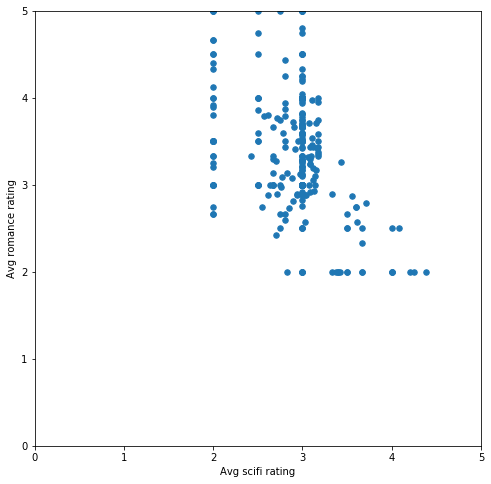

In [14]:
#We can see we have 302 users, and for each user we have their average rating of the romance and sci movies they've watched.
#Let's plot the results.

%matplotlib inline

helper.draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

# Analysis #2: Checking the best values for K

In [15]:
#We do have an info about the Benchmark model settings regards to the K value, 
#but let's choose the best value for K for our final solution.


# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

#Let's drop the Nan from the dataset
X = pd.DataFrame(X).dropna()

#Convert Dataframe back to numpy array
X = X.values

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, X) for k in possible_k_values]

In [16]:
list(zip(possible_k_values, errors_per_k))

[(2, 0.42172934075789731),
 (7, 0.47243195550039074),
 (12, 0.50548208851925081),
 (17, 0.54499137314483315),
 (22, 0.5762967521490463),
 (27, 0.59368845605400244),
 (32, 0.5845429681994716),
 (37, 0.58365337620293067),
 (42, 0.62093868503017113),
 (47, 0.63517947671851804),
 (52, 0.63926759448026904),
 (57, 0.66083827467878631),
 (62, 0.65157613304005602),
 (67, 0.67329836178314018),
 (72, 0.66241813712068842),
 (77, 0.68051652726396927),
 (82, 0.68116748690883155),
 (87, 0.6768992384154674),
 (92, 0.68805208516421401),
 (97, 0.67449017853203697),
 (102, 0.6755735842273346),
 (107, 0.67752119700575153),
 (112, 0.67062974082847326),
 (117, 0.65286008016606389),
 (122, 0.65483952030914039),
 (127, 0.64321790642524967),
 (132, 0.6336341025457003),
 (137, 0.62733033837617458),
 (142, 0.61547606691454182),
 (147, 0.60459827668432486),
 (152, 0.59372941445784444),
 (157, 0.58466559692387576),
 (162, 0.56968628717669179),
 (167, 0.55369377514560325),
 (172, 0.54485047033431988),
 (177, 0.544

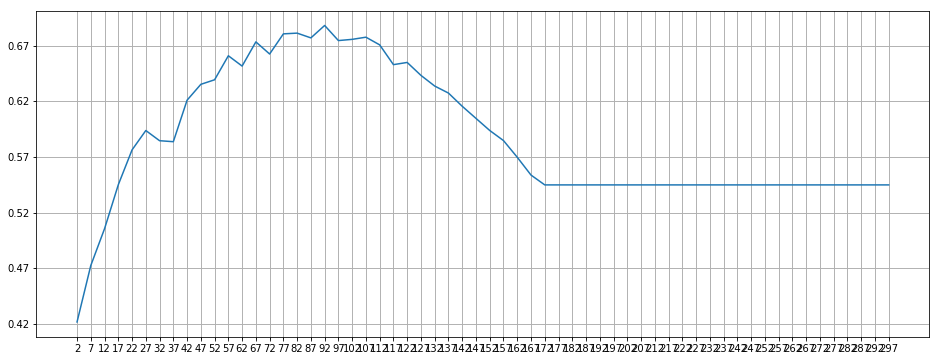

In [17]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

# Preprocessing #1: Merging Ratings and Movies Datasets

In [18]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ninteenth_movies_ratings, nignteenth_movies[['movieId', 'title']], on='movieId' )

In [19]:
print( len(ratings_title))
ratings_title.tail()

13120178


,userId,movieId,rating,timestamp,title
13120173,282869,163194,4.0,1525180432,Davy Crockett and the River Pirates (1956)
13120174,282869,181773,3.0,1525180343,Drip Dippy Donald (1948)
13120175,282869,181921,3.0,1525180365,Pluto and the Gopher (1950)
13120176,282869,182077,3.0,1525180294,Pluto's Dream House (1940)
13120177,283028,72923,2.0,1285603421,Shaolin Kung Fu Mystagogue (Da mo mi zong) (1976)


# Preprocessing #2: Minimizing Final Dataset

In [20]:
#As 13M rating causes crashes in the system, I will use with only 1k row of the dataset for building the model.
#then, we can use the entire dataset on more powerful machine 'Future Work'

In [21]:
ratings_title.sort_values(by="userId" ,inplace=True)

In [22]:
ratings_title = ratings_title[-100000:]

In [23]:
len(ratings_title)

100000

In [24]:
ratings_title.tail()

,userId,movieId,rating,timestamp,title
8484098,283228,933,5.0,1354137224,To Catch a Thief (1955)
8479832,283228,928,5.0,1354137288,Rebecca (1940)
3475849,283228,21,4.0,1354159706,Get Shorty (1995)
11867424,283228,906,5.0,1354137250,Gaslight (1944)
1872098,283228,1215,4.0,1354159841,Army of Darkness (1993)


# Preprocessing #3: Creating Pivot Tables

In [25]:
#Removing the unneccessary columns to make it suitable for the clustring.

In [26]:
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
user_movie_ratings = helper.get_most_rated_movies(user_movie_ratings, 1000)

In [27]:
len(user_movie_ratings)

2175

# Preprocessing #4: Creating csr_matrix

In [28]:
#Convering the pivot table to a csr_matrix for best clustring perofrmance.

In [29]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(user_movie_ratings).to_coo())

# Building #1: Benchmark Model

In [30]:
# As we highlighted eralier that our benchmark model uses the Kmeans algorithm with K=20

In [31]:
from sklearn.cluster import KMeans 
KMeans=KMeans(n_clusters=20, algorithm='full')
predictions = KMeans.fit_predict(sparse_ratings)

/home/workspace/helper.py:115: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/workspace/helper.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)


cluster # 1
# of users in cluster: 1176. # of users in plot: 70


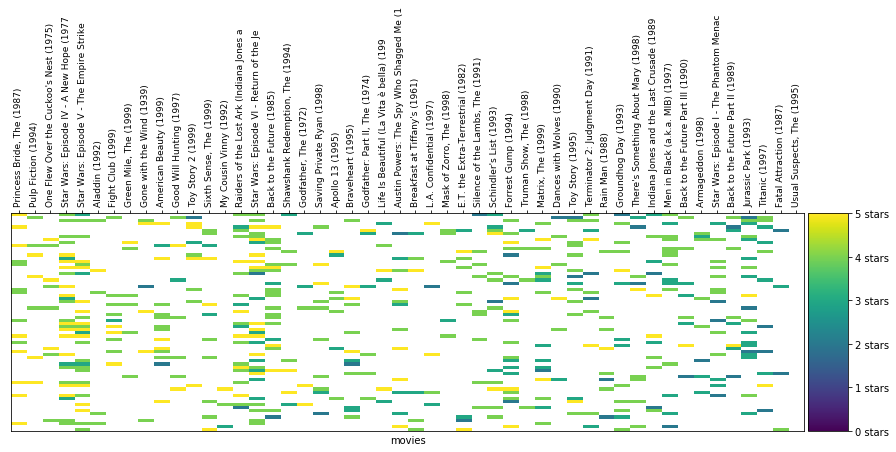

cluster # 2
# of users in cluster: 343. # of users in plot: 70


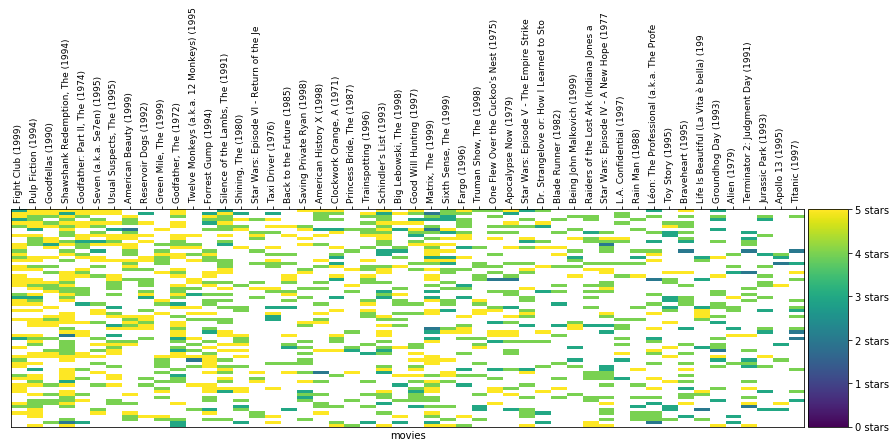

cluster # 0
# of users in cluster: 54. # of users in plot: 54


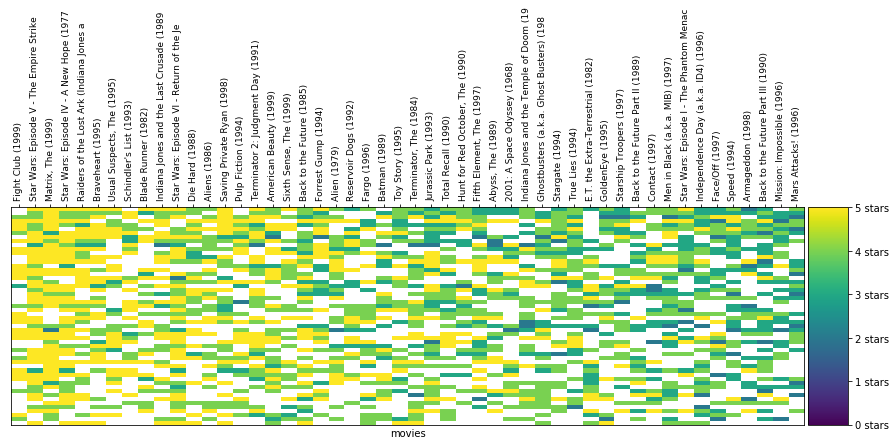

cluster # 11
# of users in cluster: 173. # of users in plot: 70


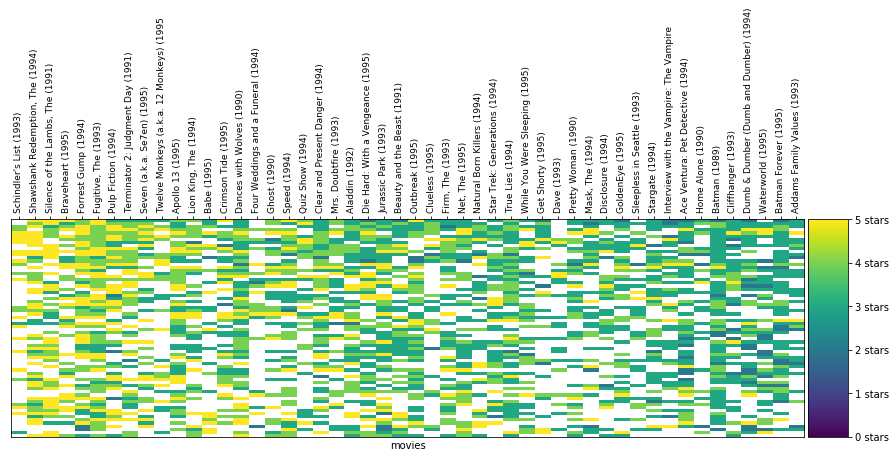

cluster # 14
# of users in cluster: 36. # of users in plot: 36


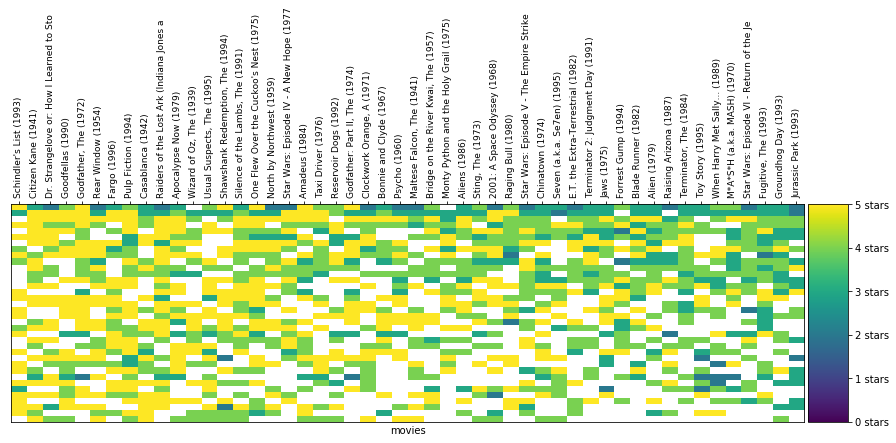

cluster # 10
# of users in cluster: 88. # of users in plot: 70


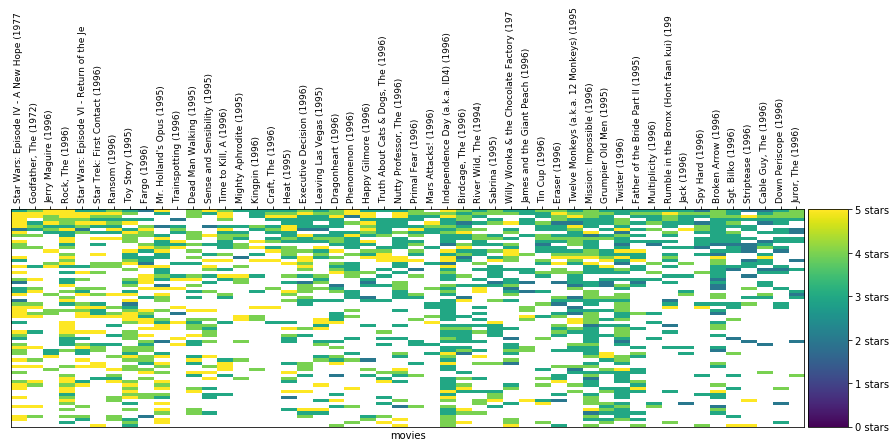

cluster # 5
# of users in cluster: 158. # of users in plot: 70


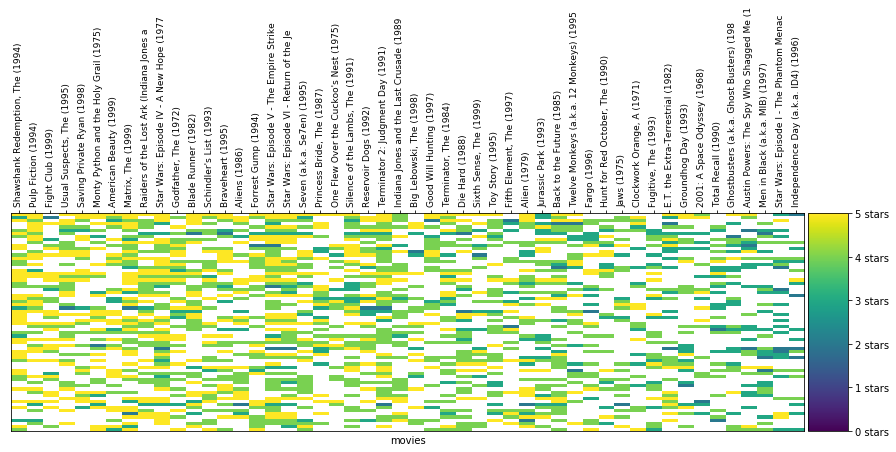

cluster # 7
# of users in cluster: 45. # of users in plot: 45


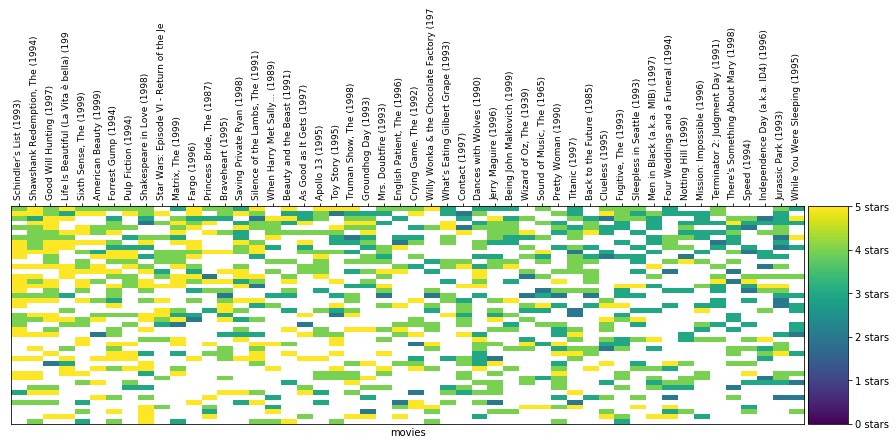

cluster # 17
# of users in cluster: 14. # of users in plot: 14


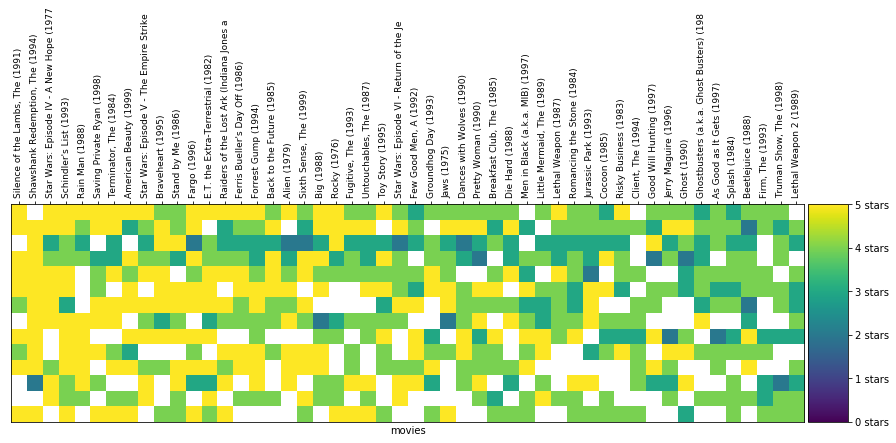

cluster # 4
# of users in cluster: 60. # of users in plot: 60


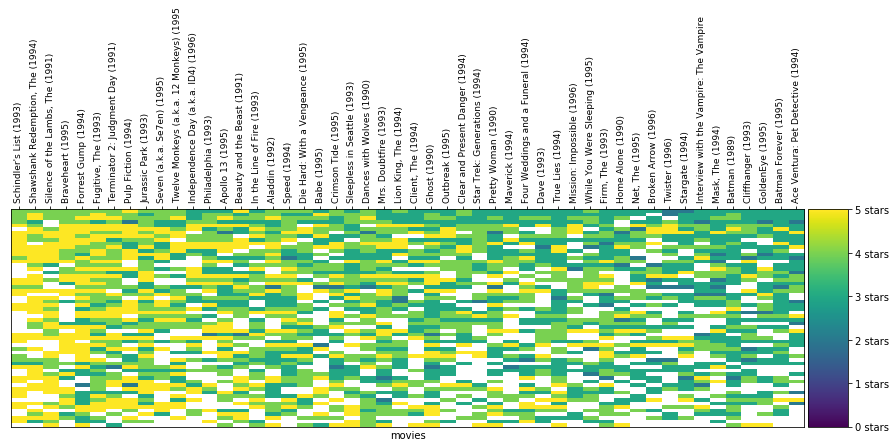

In [32]:
#Visualization on a Heat Map
max_users = 70
max_movies = 50

clustered = pd.concat([user_movie_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

# Building #2: Final Model

In [60]:
from sklearn.cluster import KMeans 
KMeans=KMeans(n_clusters=37, algorithm='full')
predictions = KMeans.fit_predict(sparse_ratings)

/home/workspace/helper.py:115: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/workspace/helper.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)


cluster # 22
# of users in cluster: 997. # of users in plot: 70


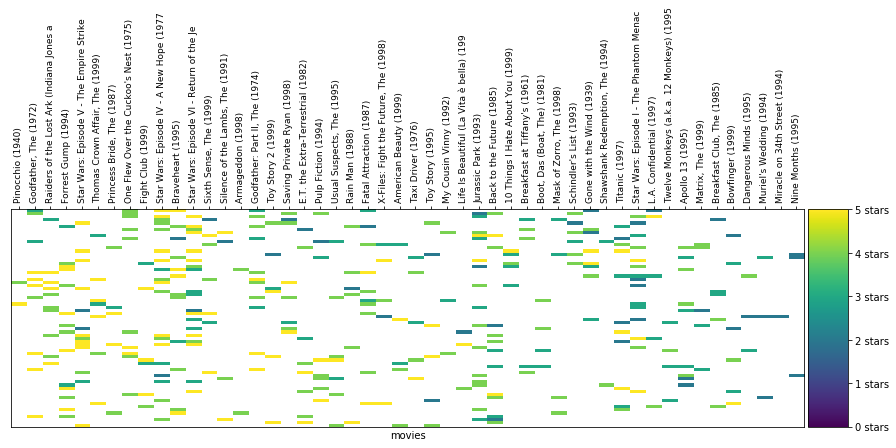

cluster # 16
# of users in cluster: 238. # of users in plot: 70


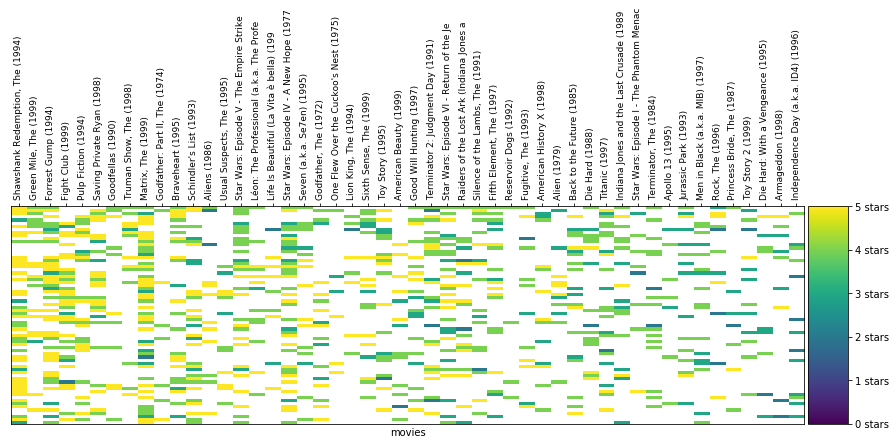

cluster # 36
# of users in cluster: 113. # of users in plot: 70


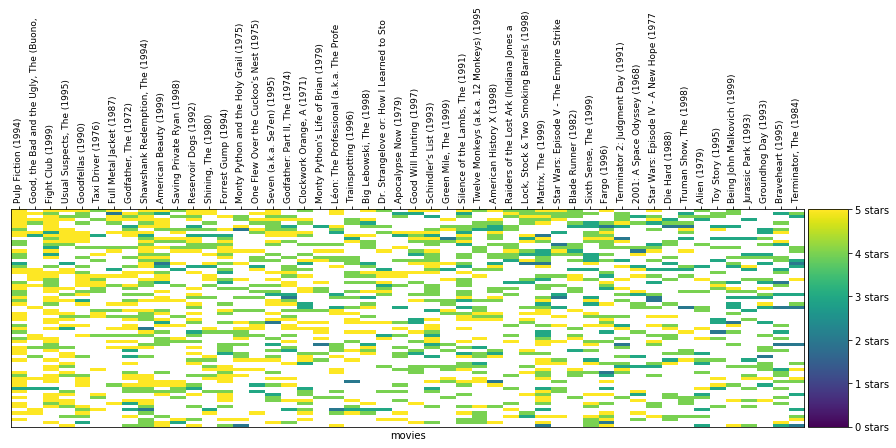

cluster # 8
# of users in cluster: 40. # of users in plot: 40


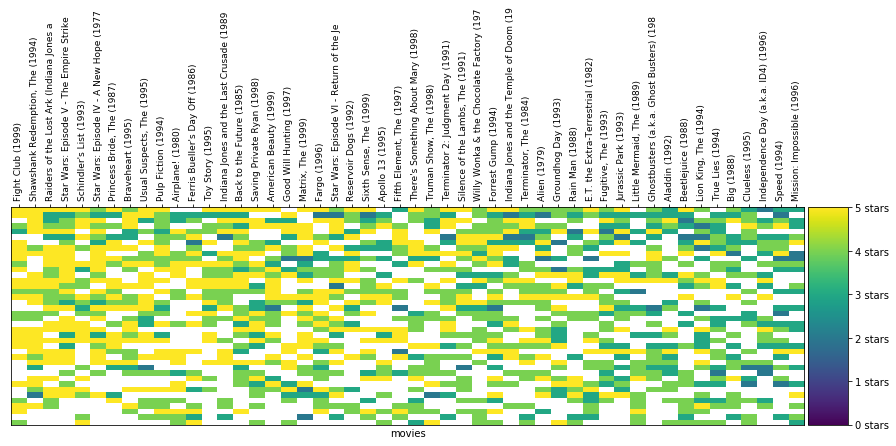

cluster # 0
# of users in cluster: 109. # of users in plot: 70


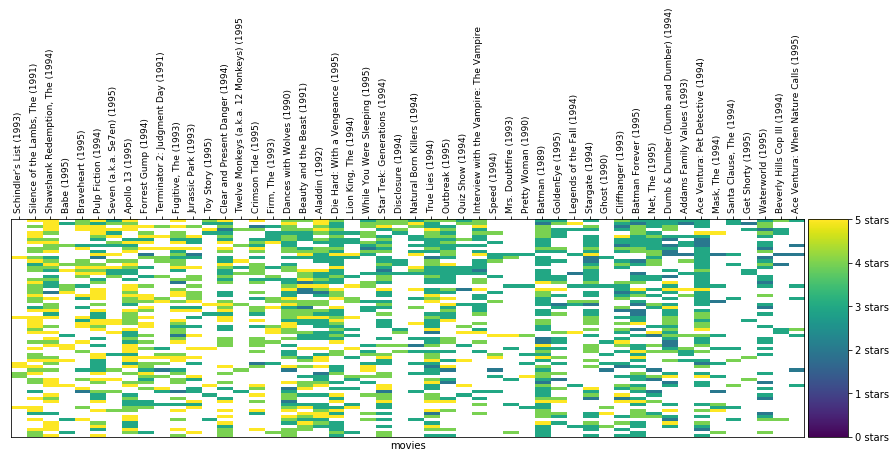

cluster # 12
# of users in cluster: 93. # of users in plot: 70


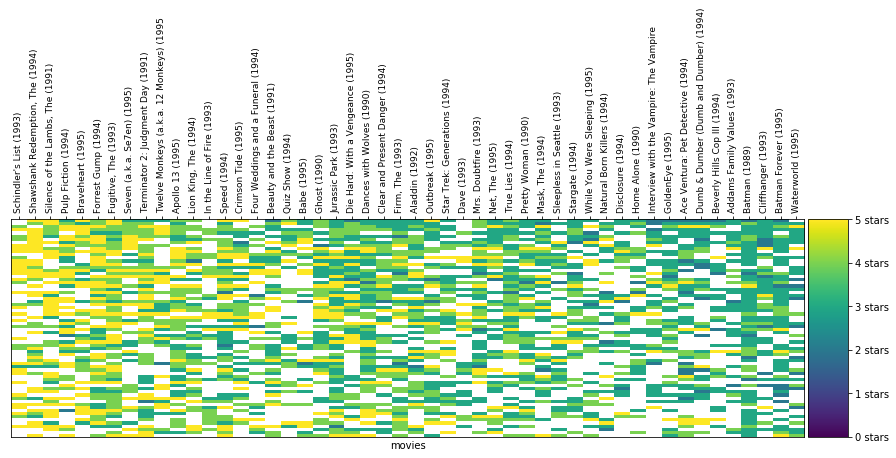

cluster # 1
# of users in cluster: 58. # of users in plot: 58


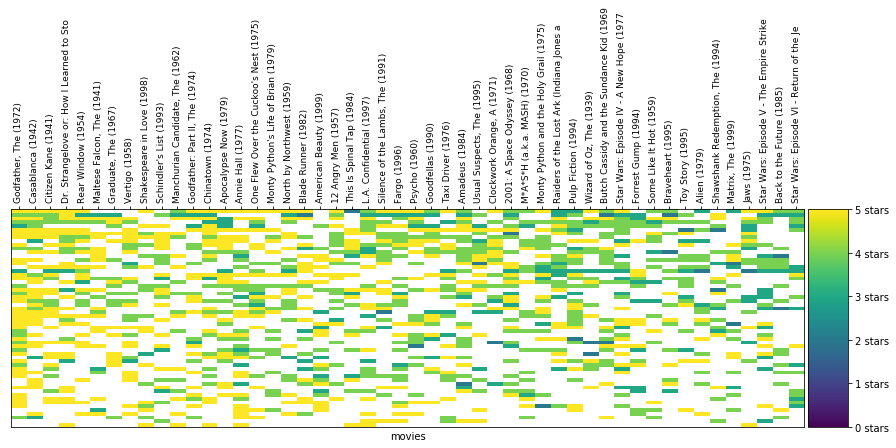

cluster # 3
# of users in cluster: 75. # of users in plot: 70


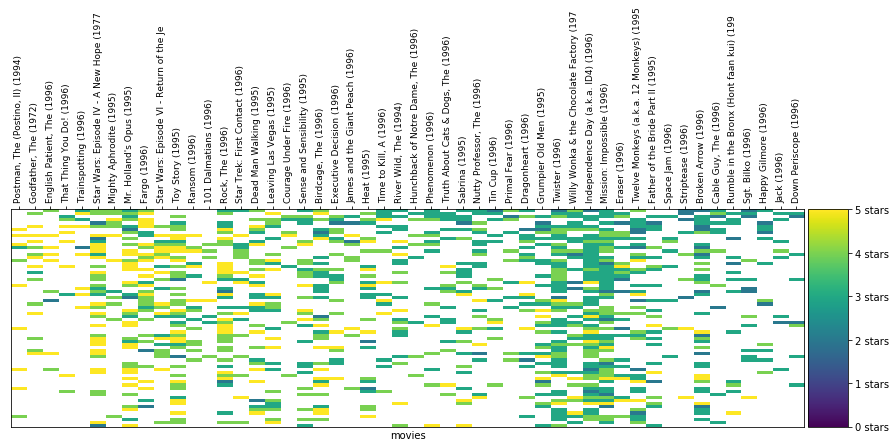

cluster # 18
# of users in cluster: 94. # of users in plot: 70


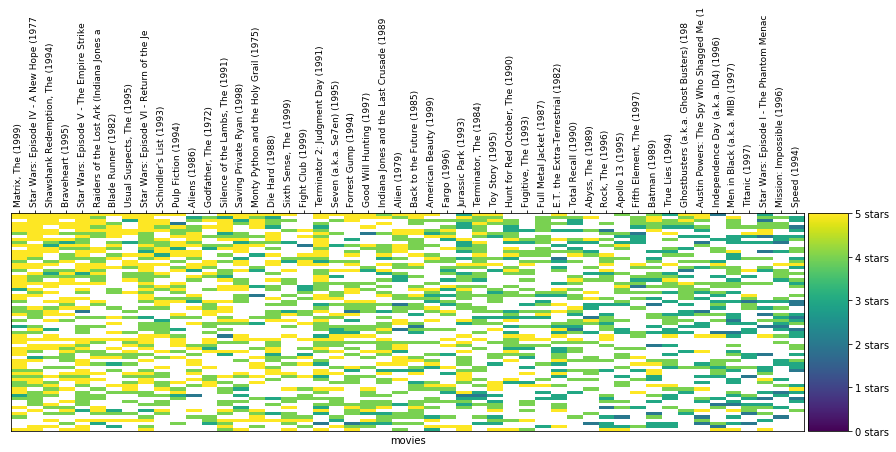

cluster # 7
# of users in cluster: 14. # of users in plot: 14


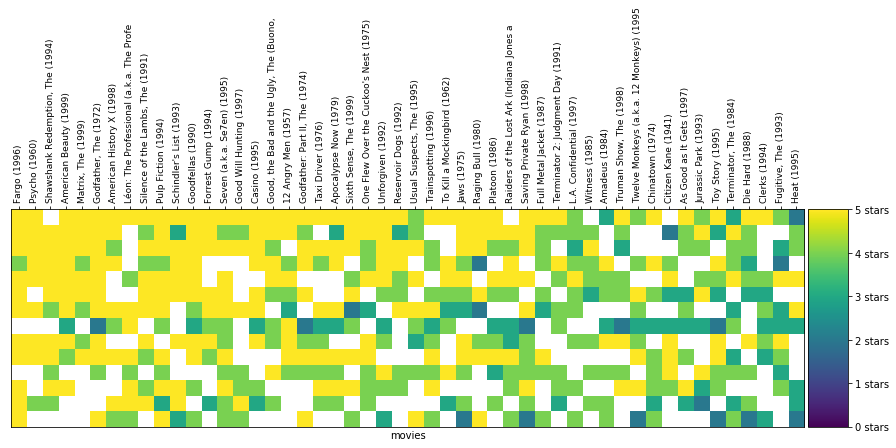

cluster # 17
# of users in cluster: 89. # of users in plot: 70


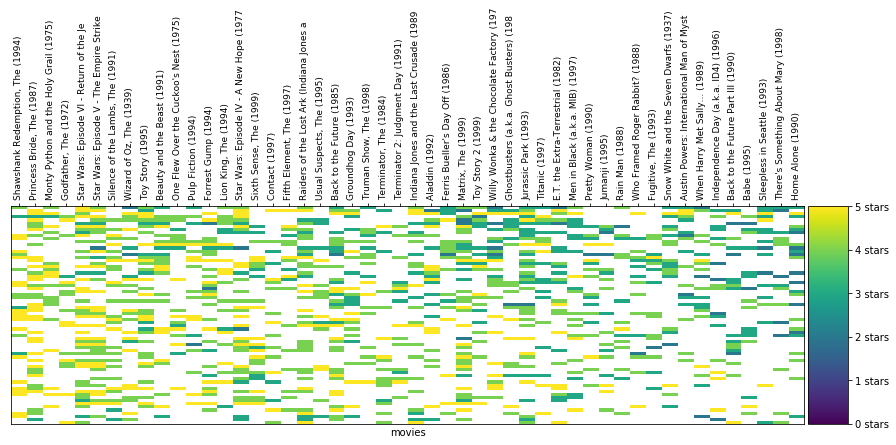

cluster # 19
# of users in cluster: 138. # of users in plot: 70


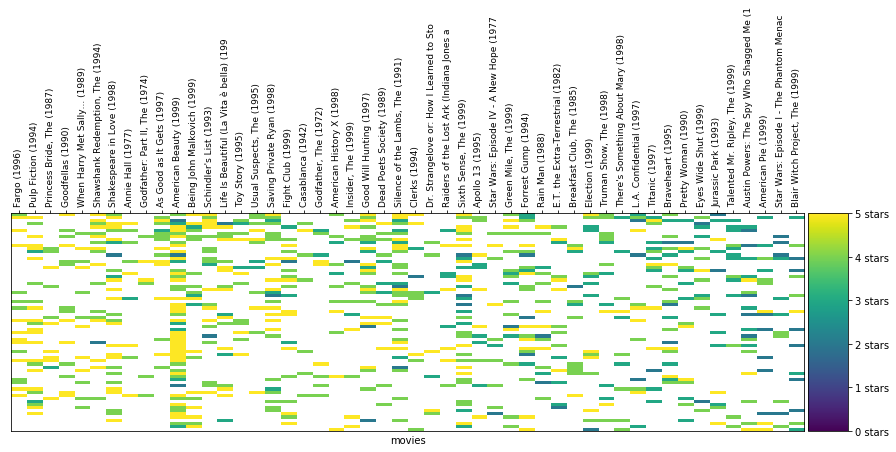

cluster # 21
# of users in cluster: 22. # of users in plot: 22


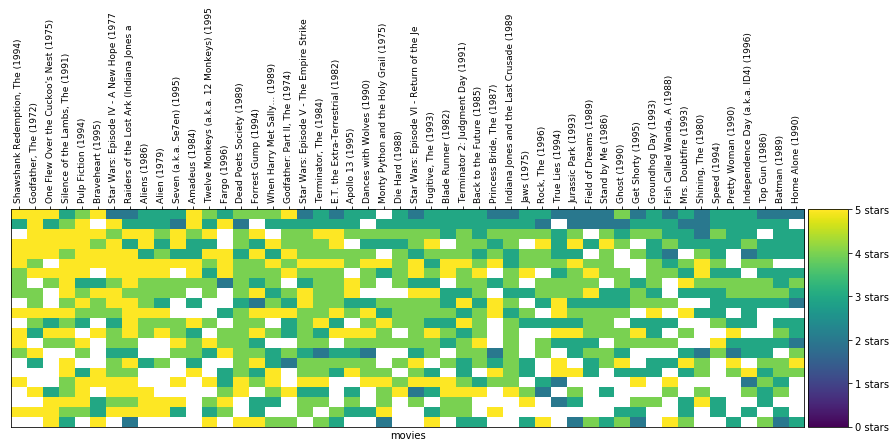

cluster # 25
# of users in cluster: 19. # of users in plot: 19


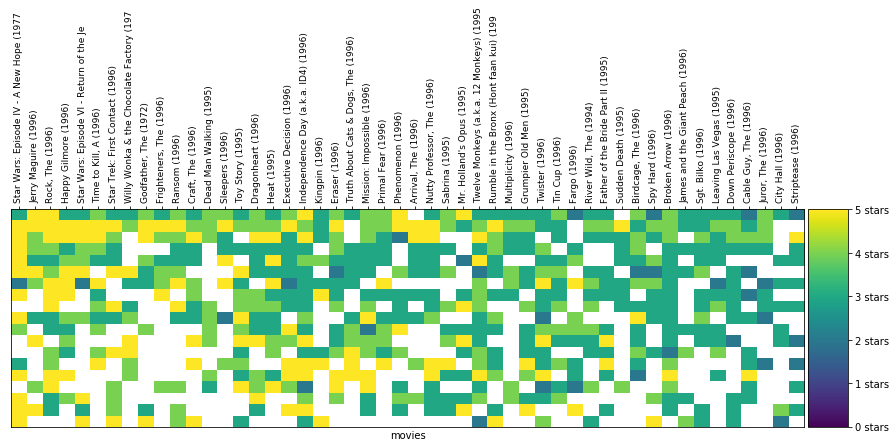

cluster # 5
# of users in cluster: 36. # of users in plot: 36


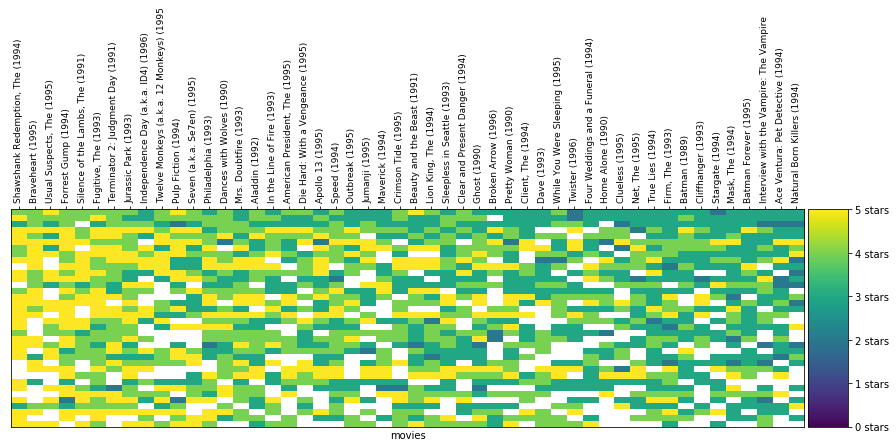

In [61]:
#Visualization on a Heat Map
max_users = 70
max_movies = 50

clustered = pd.concat([user_movie_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

# Checking Results #1: Visualizing a Cluster

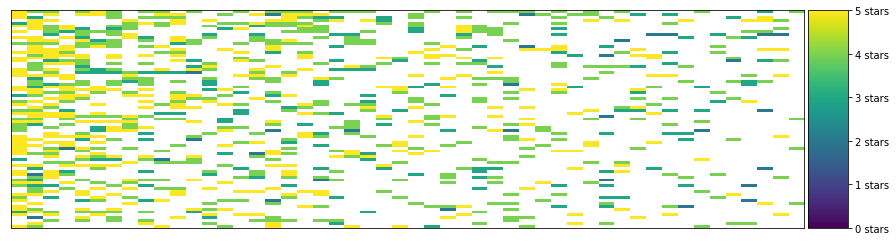

In [62]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 16

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 50
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

In [65]:
cluster.head()

,"Shawshank Redemption, The (1994)","Matrix, The (1999)",Forrest Gump (1994),Fight Club (1999),Star Wars: Episode IV - A New Hope (1977),Schindler's List (1993),Star Wars: Episode V - The Empire Strikes Back (1980),Pulp Fiction (1994),Star Wars: Episode VI - Return of the Jedi (1983),"Silence of the Lambs, The (1991)",...,Life Is Beautiful (La Vita è bella) (1997),Toy Story 2 (1999),Die Hard: With a Vengeance (1995),"Princess Bride, The (1987)",Apollo 13 (1995),Star Wars: Episode I - The Phantom Menace (1999),Armageddon (1998),"Rock, The (1996)","Lion King, The (1994)",Reservoir Dogs (1992)
34,5.0,4.0,4.0,NaN,4.0,5.0,4.0,NaN,4.0,4.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,4.0
198,5.0,NaN,5.0,NaN,5.0,5.0,4.0,NaN,NaN,5.0,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,5.0,3.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN
79,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,5.0,5.0,4.0,NaN
227,3.0,5.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Checking Results #2: Checking a Movie Mean Rating Expecation

In [66]:
# The average rating of 20 movies as rated by the users in this cluster
cluster.mean().head(20)

Shawshank Redemption, The (1994)                                                  4.625000
Matrix, The (1999)                                                                4.288462
Forrest Gump (1994)                                                               4.454545
Fight Club (1999)                                                                 4.441176
Star Wars: Episode IV - A New Hope (1977)                                         4.230769
Schindler's List (1993)                                                           4.290323
Star Wars: Episode V - The Empire Strikes Back (1980)                             4.218750
Pulp Fiction (1994)                                                               4.440000
Star Wars: Episode VI - Return of the Jedi (1983)                                 4.068966
Silence of the Lambs, The (1991)                                                  4.052632
Saving Private Ryan (1998)                                                        4.444444

In [68]:
#The expected mean for the movie in the same cluster.
movie_name = "Titanic (1997)"
cluster[movie_name].mean()

3.8333333333333335

# Checking Results #4: Recommend Movies For a User

In [69]:
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 198

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Fight Club (1999)                                                                 4.441176
Pulp Fiction (1994)                                                               4.440000
Truman Show, The (1998)                                                           4.400000
Usual Suspects, The (1995)                                                        4.307692
Matrix, The (1999)                                                                4.288462
Lion King, The (1994)                                                             4.222222
Life Is Beautiful (La Vita è bella) (1997)                                        4.222222
Seven (a.k.a. Se7en) (1995)                                                       4.187500
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)                    4.142857
American Beauty (1999)                                                            4.142857
Good Will Hunting (1997)                                                          4.100000

# Results #1: Predicting New User Data

In [70]:
#Here, I will check the cluster for the new user. Later, I will build some knowlege about the user's tast.

In [72]:
#Gett remaining colums
all_movies_columns = list(user_movie_ratings.columns)
len(all_movies_columns)

1000

In [73]:
#Creating dummy Columns in new user dataframe
new_data = pd.DataFrame()
for col in all_movies_columns:
    new_data[col] = np.NaN,

In [77]:
#Adding some ratings for the new user
new_data['Starman (1984)'] = 5
new_data['Starman (1984)'] = 5
new_data['Matrix, The (1999)'] = 5
new_data

,"Shawshank Redemption, The (1994)",Forrest Gump (1994),Pulp Fiction (1994),"Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Schindler's List (1993),Star Wars: Episode VI - Return of the Jedi (1983),Braveheart (1995),...,Bringing Out the Dead (1999),"Goofy Movie, A (1995)","Little Rascals, The (1994)",Terminal Velocity (1994),Rising Sun (1993),Starman (1984),Cat on a Hot Tin Roof (1958),"Wild Bunch, The (1969)","Mosquito Coast, The (1986)",Body Snatchers (1993)
0,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN


In [78]:
#Converting the new user data to a sparce metrix
new_data = csr_matrix(pd.SparseDataFrame(new_data).to_coo())

In [79]:
#Predicting a cluster for the new data
KMeans.predict(new_data)

array([22], dtype=int32)

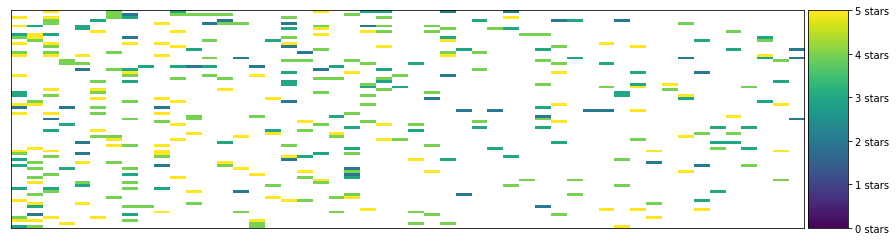

In [81]:
# Visualizing the data of the cluster
cluster_number = 22

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 50
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

In [84]:
#Getting the top 20 recommendatio for the new user
cluster.mean().head(20)

Star Wars: Episode VI - Return of the Jedi (1983)                                 4.045455
Forrest Gump (1994)                                                               4.176471
Star Wars: Episode IV - A New Hope (1977)                                         4.150000
Matrix, The (1999)                                                                3.500000
Titanic (1997)                                                                    3.454545
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.363636
One Flew Over the Cuckoo's Nest (1975)                                            4.200000
Jurassic Park (1993)                                                              3.611111
Shawshank Redemption, The (1994)                                                  3.500000
Star Wars: Episode V - The Empire Strikes Back (1980)                             4.285714
Godfather, The (1972)                                                             4.400000